2018.01.17

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from pygeocoder import Geocoder
from mpl_toolkits.basemap import Basemap

%matplotlib inline

## Import the csv

In [2]:
# where this data came from: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1
orig_data = pd.read_csv('./project_datasets/682464398_102017_1651_airline_delay_causes.csv', skipinitialspace=True)

## Clean the data

### drop the extraneous column that has no information

In [3]:
data_right_columns = orig_data.drop('Unnamed: 21', axis=1)

Some of the column names have initial space, so we use a regular expression  

to make them easier to work with programmatically

In [4]:
columns = []
for i, col in enumerate(data_right_columns.columns):
    global columns
    col = re.sub(r'\s+', '', col)
    columns.append(col)
data_right_columns.columns = columns
data_right_columns.columns

Index([u'year', u'month', u'carrier', u'carrier_name', u'airport',
       u'airport_name', u'arr_flights', u'arr_del15', u'carrier_ct',
       u'weather_ct', u'nas_ct', u'security_ct', u'late_aircraft_ct',
       u'arr_cancelled', u'arr_diverted', u'arr_delay', u'carrier_delay',
       u'weather_delay', u'nas_delay', u'security_delay',
       u'late_aircraft_delay'],
      dtype='object')

### Dropping the NaN rows as invalid data, it is a small percentage of the entire dataset

In [5]:
data_right_columns.shape

(11193, 21)

In [6]:
data_NoNaN = data_right_columns.dropna(axis=0)

So, the Nans have been dropped...

### We wil now use the first variable, `data_NoNaN` and set it to `data` ...

The next four strategies of NaN handling are commented out, but also will be `data`

In [7]:
data = data_NoNaN

Looking at the shape of our data, the 18 dropped values, give us 11173 observations and 21 features

In [8]:
data.shape

(11173, 21)

# Target
We have determined that the goal of this data analysis is to predict delayed flights, given certain conditions based on the dataset.  Therefore the target variable is `arr_del15`




Let's make the target variable binary.

In [9]:
data['target'] = [1 if targ >= 15.0 else 0 for targ in data.arr_del15]
data['target'].value_counts()

/Users/jg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    6651
0    4522
Name: target, dtype: int64

#### Now that `target_x` has been created and added to the dataframe, `data`, `arr_del15` needs to be dropped since it is now redundant

In [10]:
data = data.drop('arr_del15', axis=1)
data.columns

Index([u'year', u'month', u'carrier', u'carrier_name', u'airport',
       u'airport_name', u'arr_flights', u'carrier_ct', u'weather_ct',
       u'nas_ct', u'security_ct', u'late_aircraft_ct', u'arr_cancelled',
       u'arr_diverted', u'arr_delay', u'carrier_delay', u'weather_delay',
       u'nas_delay', u'security_delay', u'late_aircraft_delay', u'target'],
      dtype='object')

`data.columns` is a list of all 21 features including the target variable

In [11]:
len(data.columns)

21

# Statistical Analysis  0.0

In [12]:
data.describe()

year         month   arr_flights    carrier_ct    weather_ct  \
count  11173.0  11173.000000  11173.000000  11173.000000  11173.000000   
mean    2016.0      6.025239    461.532892     22.628786      2.278168   
std        0.0      3.157616   1170.892758     51.024876      6.806785   
min     2016.0      1.000000      1.000000      0.000000      0.000000   
25%     2016.0      3.000000     60.000000      2.720000      0.000000   
50%     2016.0      6.000000    133.000000      7.520000      0.270000   
75%     2016.0      9.000000    343.000000     19.300000      1.740000   
max     2016.0     11.000000  21977.000000   1242.160000    168.440000   

             nas_ct   security_ct  late_aircraft_ct  arr_cancelled  \
count  11173.000000  11173.000000      11173.000000   11173.000000   
mean      24.216326      0.146415         27.759464       5.226528   
std       66.990992      0.578833         72.339762      20.253243   
min        0.000000      0.000000          0.000000       0.000000   
25%        1.440000      0.000000          1.950000       0.000000   
50%        4.770000      0.000000          6.310000       1.000000   
75%       14.010000      0.000000         18.520000       3.000000   
max     1092.620000     11.730000       1320.090000     598.000000   

       arr_diverted      arr_delay  carrier_delay  weather_delay  \
count  11173.000000   11173.000000   11173.000000   11173.000000   
mean       1.109371    4762.861541    1557.819565     203.253379   
std        4.600183   12999.978334    4469.262529     674.118573   
min        0.000000       0.000000       0.000000       0.000000   
25%        0.000000     419.000000     139.000000       0.000000   
50%        0.000000    1174.000000     452.000000      14.000000   
75%        1.000000    3334.000000    1226.000000     133.000000   
max      110.000000  395609.000000  196944.000000   17400.000000   

          nas_delay  security_delay  late_aircraft_delay        target  
count  11173.000000    11173.000000         11173.000000  11173.000000  
mean    1140.141233        6.610669          1855.036696      0.595274  
std     3690.589513       31.161224          5125.250783      0.490861  
min        0.000000        0.000000             0.000000      0.000000  
25%       49.000000        0.000000           102.000000      0.000000  
50%      173.000000        0.000000           404.000000      1.000000  
75%      550.000000        0.000000          1308.000000      1.000000  
max    74898.000000      933.000000        129200.000000      1.000000

We gain little insight into the dataset by calling `describe()` so early into the data analysis.  

Note that the categorical variables `'carrier'`, `'carrier_name'`, `'airport'` and `'airport_name'` are not included in the `.describe()` statistics.

We need to describe the data in a way that can be used as reasonable arguments for correlation between variables.

# Modeling

X is the dataset and y is the target

In [13]:
X = data.iloc[:, 6:20]
y = data.iloc[:, 20]

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
logit_reg = LogisticRegression()

In [18]:
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
print ("Test set score: {:.2f}".format(logit_reg.score(X_test, y_test)))

Test set score: 0.98


### Cross-Validation in Sci-Kit Learn

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
logit_reg2 = LogisticRegression()
scores2 = cross_val_score(logit_reg2, X, y)

In [22]:
print ("Cross-Validation Score:{}".format(scores2))

Cross-Validation Score:[ 0.97100671  0.99516649  0.99355532]


In [23]:
print ("Average Cross-Validation Score:{}".format(scores2.mean()))

Average Cross-Validation Score:0.986576171974


### K-Fold Cross-Validation in Sci-Kit Learn

In [24]:
from sklearn.model_selection import KFold

In [25]:
kfold = KFold(n_splits=2)

In [26]:
print ("Cross-Validation Scores:".format(cross_val_score(logit_reg2, X, y, cv=kfold)))

Cross-Validation Scores:


### Stratified kFold

# Re-Do Modeling with better data
There are many data columns that may produce a result when fit into our models, but the numbers they output do not make sense.  Our largest data-grouping is by categorical and numeric variables.


As such, the split will be columns --d-- through --d--


Additionally, we need to create dummy variable columns for some of the data so that, though it is categorical it will fit models and be calculated as if it were numeric.

## Group by Categorical / Numeric

In [27]:
col_numeric = data.select_dtypes(include=[np.number]).columns.tolist()
col_categorical = data.select_dtypes(include=[np.object]).columns.tolist()

`select_dtypes()` selected `year` and `month` as numeric. They are now separated so that pure numeric columns may be seen graphically


Use `year` and `month` separately in the `col_year_month` variable

In [28]:
# `col_year_month` is the first variable we see below in the Quick Summary__________ first [1st]
col_year_month = col_numeric[0:2]
col_year_month

['year', 'month']

### Remove redundant columns
Of the four columns in `col_categorical`, only two are relevant since the other two contain the same information

In [29]:
# the `data2` variable holds the `col_categorical` because when we color the redundant columns, the 
# programming that does the coloring disables other DataFrame methods and functions we will need for analysis
data2 = data[col_categorical]
# function examines value's length, and returns red if its too long
def longstring_red(val):
    val = len(str(val)); color = 'red' if val >3 else 'black'; return 'color: %s' % color
# apply the function
redundant_red = data2[:5].style.applymap(longstring_red)
redundant_red

In [30]:
# remove redundant columns
# `col_categorical` is the second variable we see below in the Quick Summary__________ second [2nd]
col_categorical = col_categorical[0::2]
col_categorical

['carrier', 'airport']

In [31]:
# This is much tider and can be used easily for stats and modeling
data[col_categorical].head()

carrier airport
0      AA     DFW
1      AA     DTW
2      AA     SEA
3      AA     JFK
4      AA     SJC

In [32]:
data[col_categorical].sample(10)

carrier airport
1930       WN     LAS
4835       OO     INL
3151       AS     CDV
9777       NK     PDX
6141       AA     SYR
8365       DL     BTR
7108       AA     LGA
2728       OO     HYS
11092      VX     JFK
2517       EV     AGS

In [33]:
# col_numeric
# ['year','month','arr_flights','carrier_ct','weather_ct','nas_ct',
#  'security_ct','late_aircraft_ct','arr_cancelled','arr_diverted',
#  'arr_delay','carrier_delay','weather_delay','nas_delay','security_delay',
#  'late_aircraft_delay','target']

### Separate the target so it can be treated separately

In [34]:
# `col_target` is the third variable we see below in the Quick Summary__________ third [3rd]
col_target = col_numeric[16:17]
col_target

['target']

### Numeric Columns

In [35]:
# rename `col_numeric` so it does not include 'year' and 'month'
# `col_numeric` is the fourth variable we see below in the Quick Summary__________ fourth [4th]
col_numeric = col_numeric[2:16]
# col_numeric

['arr_flights',
 'carrier_ct',
 'weather_ct',
 'nas_ct',
 'security_ct',
 'late_aircraft_ct',
 'arr_cancelled',
 'arr_diverted',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

##### Quick Summary of the groups of variables we created that when concatenated, represent the entire dataset(19 features), notincluding the redundant categorical columns and including the binarized target column.

` col_year_month `,  ` col_categorical `, ` col_target `, ` col_numeric `

In [36]:
print("Quick Summary:")
print("[1st] col_categorical:", col_categorical);print("");
print("[2nd] col_year_month:", col_year_month);print("");
print("[3rd] col_numeric:", col_numeric);print("");
print("[4th] col_target:", col_target)

Quick Summary:
('col_categorical:', ['carrier', 'airport'])

('col_year_month:', ['year', 'month'])

('col_numeric:', ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'])

('col_target:', ['target'])


### Combine the lists

In [76]:
pre_combine = [col_year_month, col_categorical, col_numeric, col_target]
combined_list = [item for sublist in pre_combine for item in sublist]
# combined_list
# ['year', 'month', 'carrier', 'airport', 'arr_flights', 'carrier_ct', 'weather_ct', 
#  'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 
#  'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 
#  'late_aircraft_delay', 'target']

In [39]:
data[combined_list].columns

Index([u'year', u'month', u'carrier', u'airport', u'arr_flights',
       u'carrier_ct', u'weather_ct', u'nas_ct', u'security_ct',
       u'late_aircraft_ct', u'arr_cancelled', u'arr_diverted', u'arr_delay',
       u'carrier_delay', u'weather_delay', u'nas_delay', u'security_delay',
       u'late_aircraft_delay', u'target'],
      dtype='object')

Variations of a function that gets the `.iloc` number of a column

In [57]:
# can use various combination of this to get the `.iloc` number of each column

# # data[combined_list]
# for i, item_ in enumerate(data[combined_list].columns):
#     print("{}: {}".format(i, item_))

# # data[col_categorical]
# for i2, item_2 in enumerate(data[col_categorical].columns):
#     print("{}: {}".format(i2, item_2))

# # data[col_numeric]
# for i3, item_3 in enumerate(data[col_numeric].columns):
#     print("{}: {}".format(i3, item_3))

## All Airports Grouping

In [62]:
all_airports_grouping = data[combined_list].iloc[:, [2,3,5, 18]].groupby(by=['airport'])
all_airports_grouping.sum().head()

carrier_ct  target
airport                    
ABE          153.57      12
ABI           10.82       0
ABQ          992.02      39
ABR           17.57       0
ABY           82.53       5

only showing the first five columns

## Denver Groupings

In [74]:
Denver_grouping = data[combined_list][data[combined_list].airport == 'DEN'].iloc[:, [2,3,5, 18]].groupby(by=['airport', 'carrier'])
Denver_grouping.sum()

carrier_ct  target
airport carrier                    
DEN     AA           718.90      11
        AS            71.55       6
        B6            93.23       9
        DL           427.88      11
        F9           763.01      11
        NK           124.74      11
        OO          1414.07      11
        UA          2077.87      11
        VX            23.79       5
        WN          2469.61      11

An interesting computation that gets carrier names belonging to an airport

since the string values are indexes of the grouped data, we access their values differently

we could apply it on each airport grouping

- DEN, ABQ, DFW, LAX, etc

In [86]:
Denver_grouping.sum().index.values

array([('DEN', 'AA'), ('DEN', 'AS'), ('DEN', 'B6'), ('DEN', 'DL'),
       ('DEN', 'F9'), ('DEN', 'NK'), ('DEN', 'OO'), ('DEN', 'UA'),
       ('DEN', 'VX'), ('DEN', 'WN')], dtype=object)

In [87]:
Denver_Airport, DEN_carriers_ = zip(*Denver_grouping.sum().index.values)
print (Denver_Airport),
print "\n"
print (DEN_carriers_)

('DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN') 

('AA', 'AS', 'B6', 'DL', 'F9', 'NK', 'OO', 'UA', 'VX', 'WN')


### ABQ Grouping

In [66]:
ABQ_grouping = data[combined_list][data[combined_list].airport == 'ABQ'].iloc[:, [2,3,5, 18]].groupby(by=['airport', 'carrier'])
ABQ_grouping.sum()

carrier_ct  target
airport carrier                    
ABQ     AA           117.72      11
        AS            10.60       0
        B6            35.99       1
        DL            64.28       4
        EV             9.63       0
        OO           100.56      10
        UA            44.38       2
        WN           608.86      11

Apply the previous function to see the carriers in ABQ

In [88]:
air_port, carrier_ = zip(*ABQ_grouping.sum().index.values)
print (air_port),
print "\n"
print (carrier_)

('ABQ', 'ABQ', 'ABQ', 'ABQ', 'ABQ', 'ABQ', 'ABQ', 'ABQ') 

('AA', 'AS', 'B6', 'DL', 'EV', 'OO', 'UA', 'WN')


### DFW Grouping

In [67]:
DFW_grouping = data[combined_list][data[combined_list].airport == 'DFW'].iloc[:, [2,3,5, 18]].groupby(by=['airport', 'carrier'])
DFW_grouping.sum()

carrier_ct  target
airport carrier                    
DFW     AA          6442.09      11
        AS            43.05       3
        B6            37.88       1
        DL           253.52      11
        EV          1394.79      11
        F9            49.03       7
        NK           280.75      11
        OO           231.33      11
        UA           235.53      11

### LAX Grouping

In [68]:
LAX_grouping = data[combined_list][data[combined_list].airport == 'LAX'].iloc[:, [2,3,5, 18]].groupby(by=['airport', 'carrier'])
LAX_grouping.sum()

carrier_ct  target
airport carrier                    
LAX     AA          2548.23      11
        AS           231.67      11
        B6           343.82      11
        DL          1409.35      11
        F9           108.22      10
        HA           218.87       6
        NK           343.55      11
        OO           629.21      11
        UA          1862.86      11
        VX           720.88      11
        WN          2197.97      11

## Carrier Groupings

In [73]:
new_grouping = data[combined_list][data[combined_list].airport == 'LAX'].iloc[:, [2,3,5, 18]].groupby(by=['airport', 'carrier'])
new_grouping.sum()

carrier_ct  target
airport carrier                    
LAX     AA          2548.23      11
        AS           231.67      11
        B6           343.82      11
        DL          1409.35      11
        F9           108.22      10
        HA           218.87       6
        NK           343.55      11
        OO           629.21      11
        UA          1862.86      11
        VX           720.88      11
        WN          2197.97      11

Use `.describe()` to find the 50% quantile of `late_aircraft_delay`.

In [113]:
data.late_aircraft_delay.quantile(.5)

404.0

In [106]:
data.late_aircraft_delay.describe()

count     11173.000000
mean       1855.036696
std        5125.250783
min           0.000000
25%         102.000000
50%         404.000000
75%        1308.000000
max      129200.000000
Name: late_aircraft_delay, dtype: float64

## Statistical groupings

In [141]:
new_grouping33 = data[combined_list][data[combined_list].late_aircraft_delay == 129200].iloc[:, [2,3,5, 17,18]].groupby(by=['airport', 'carrier'])
new_grouping33.sum()

carrier_ct  late_aircraft_delay  target
airport carrier                                         
ATL     DL          1242.16             129200.0       1

In [127]:
# groups with target == 0
new_grouping34 = data[combined_list][data[combined_list].late_aircraft_delay == 404.0].iloc[:, [2,3,5, 17,18]].groupby(by=['airport', 'carrier'])
new_grouping34.sum()[new_grouping33.sum().target==0]

carrier_ct  late_aircraft_delay  target
airport carrier                                         
DTW     UA             4.97                404.0       0
HOB     EV             2.29                404.0       0

In [129]:
# groups with target == 1
new_grouping35 = data[combined_list][data[combined_list].late_aircraft_delay == 404.0].iloc[:, [2,3,5, 17,18]].groupby(by=['airport', 'carrier'])
new_grouping35.sum()[new_grouping33.sum().target==1]

carrier_ct  late_aircraft_delay  target
airport carrier                                         
CHS     DL             7.89                404.0       1
CLE     DL            12.52                404.0       1
CLT     EV             5.03                404.0       1
MBS     OO             5.88                404.0       1
MLU     EV            23.05                404.0       1
ROC     B6            10.43                404.0       1

In [109]:
new_grouping33.sum().index.values

array([('CHS', 'DL'), ('CLE', 'DL'), ('CLT', 'EV'), ('DTW', 'UA'),
       ('HOB', 'EV'), ('MBS', 'OO'), ('MLU', 'EV'), ('ROC', 'B6')], dtype=object)

In [108]:
# similar to the function above, this tuple-grabber gets the list of airports
air_port, carrier_ = zip(*new_grouping33.sum().index.values)
print (air_port),
print "\n"
print (carrier_)

##### How do late flights correspond to cancelled and diverted flights?

...ie, what percentage of lates become diverted, or cancelled

`target` column is the count of lates

In [156]:
lates_cancelled_grouping = data[combined_list].iloc[:, [2,3,11,10,18]].groupby(by=['airport', 'carrier'])
lates_cancelled_grouping.sum().head()

arr_diverted  arr_cancelled  target
airport carrier                                     
ABE     DL                2.0            1.0       0
        EV                4.0           34.0      11
        OO                0.0            0.0       1
ABI     EV                0.0            3.0       0
ABQ     AA                0.0           18.0      11

of ABQ's 117 AA flights, none were diverted, 18 were cancelled, and 11 were delayed

In [208]:
# we could also do this one by relevant airports
lates_cancelled_grouping_by_carrier = data[combined_list].iloc[:, [1, 2,3,5,10,11,18]].groupby(by=['month','airport', 'carrier'])
lates_cancelled_grouping_by_carrier.sum()[lates_cancelled_grouping_by_carrier.sum().target==1]

carrier_ct  arr_cancelled  arr_diverted  target
month airport carrier                                                 
1     ABE     EV            12.76            7.0           2.0       1
      ABQ     AA            14.55            1.0           0.0       1
              OO            19.43            0.0           0.0       1
              WN            32.20            6.0           2.0       1
      ACV     OO            13.79            5.0           1.0       1
      ACY     NK            23.12           17.0           0.0       1
      AEX     EV            16.49            2.0           2.0       1
      AGS     EV            16.81            1.0           0.0       1
      ALB     WN            23.05           12.0           0.0       1
      AMA     WN             3.72            1.0           0.0       1
      ANC     AS            25.59           12.0           0.0       1
      ASE     OO            31.46           19.0          26.0       1
      ATL     AA            65.61           21.0           0.0       1
              DL           644.81          221.0          10.0       1
              EV           187.26           62.0           1.0       1
              F9            11.19            5.0           0.0       1
              NK            51.88           10.0           0.0       1
              OO            30.32            9.0           3.0       1
              UA            12.71           15.0           0.0       1
              WN           154.52           86.0           3.0       1
      ATW     EV            11.65            4.0           1.0       1
              OO             2.48            1.0           0.0       1
      AUS     AA            41.91           10.0           1.0       1
              B6            13.27            4.0           0.0       1
              DL            10.44            5.0           0.0       1
              OO            17.54            0.0           1.0       1
              UA            14.05            1.0           0.0       1
              WN            65.50           13.0           0.0       1
      AVL     EV            12.83            3.0           0.0       1
      AVP     EV             7.41            8.0           0.0       1
...                           ...            ...           ...     ...
11    SNA     AA            21.35            1.0           2.0       1
              AS            10.93            0.0           0.0       1
              OO             8.80            3.0           0.0       1
              UA            14.76            0.0           2.0       1
              WN            46.65            1.0           0.0       1
      STL     AA            36.13            4.0           0.0       1
              DL            21.32            0.0           0.0       1
              EV            14.27            1.0           0.0       1
              WN           102.51            2.0           2.0       1
      STT     AA            11.15            0.0           0.0       1
      SYR     B6            10.51            0.0           0.0       1
              OO             8.10            0.0           0.0       1
      TPA     AA            43.47            2.0           0.0       1
              B6            20.25            0.0           0.0       1
              DL            29.66            0.0           0.0       1
              NK             9.17            3.0           0.0       1
              UA            12.33            0.0           0.0       1
              WN            65.16            0.0           1.0       1
      TRI     EV            13.24            0.0           0.0       1
      TTN     F9             2.92            1.0           0.0       1
      TUL     AA            20.62            0.0           0.0       1
              EV             8.59            1.0           0.0       1
              WN            17.79            0.0           0.0       1
      TUS     AA            25.50            1.

In [ ]:
DEN_lates_cancelled_grouping_by_carrier = data[combined_list].iloc[:, [1, 2,3,5,10,11,18]].groupby(by=['month','airport', 'carrier'])
DEN_lates_cancelled_grouping_by_carrier.sum()

In [154]:
# # this little for loop helps find the column numbers when slicing with .iloc
for i, x in enumerate(data[combined_list].columns):
    print("%d. %s"%(i, x))

0. year
1. month
2. carrier
3. airport
4. arr_flights
5. carrier_ct
6. weather_ct
7. nas_ct
8. security_ct
9. late_aircraft_ct
10. arr_cancelled
11. arr_diverted
12. arr_delay
13. carrier_delay
14. weather_delay
15. nas_delay
16. security_delay
17. late_aircraft_delay
18. target


Group by month, airport, airline, delays

In [206]:
month_airport_carrier = data[combined_list].iloc[:, [1, 2,3,10,11,18]].groupby(by=['airport', 'carrier'])
month_airport_carrier.sum()[month_airport_carrier.sum().month==1]

month  arr_cancelled  arr_diverted  target
airport carrier                                            
BHM     AA           1            0.0           0.0       0
BTR     UA           1            1.0           0.0       0
DAB     EV           1            0.0           0.0       0
DAL     EV           1            0.0           0.0       0

### Plot AUC Curve

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [87]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logit_reg.predict_proba(X_test)[:,1]

In [88]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.997023124309


In [89]:
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logit_reg, X, y, cv=5, scoring='roc_auc')

In [90]:
# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [ 0.99858454  0.99998255  0.999916    0.99997588  0.99984613]


## Back to Logistic Regression

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [93]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.989


### GridSearchCV

In [94]:
# from sklearn.model_selection import GridSearchCV

# param_grid = { 'n_neighbors': np.arange( 1, 50 ) }
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV( logreg, param_grid, cv=5 )
# logreg_cv.fit( X, y )


# print(logreg_cv.best_params_),
# print(logreg_cv.best_score_)


## Comparing Algorithms

In [61]:
# this cell takes about 90 seconds to run,... mostly bc of SVM
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

seed = 42
# prepare list for models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNearestneighbors', KNeighborsClassifier()))
models.append(('Classification And Regression Trees', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('RFRg', RandomForestRegressor(n_estimators = 100,oob_score = True, n_jobs = -1, random_state=seed)))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.991945 (0.006417)


/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.626157 (0.092132)
KNearestneighbors: 0.942091 (0.007824)
Classification And Regression Trees: 0.969300 (0.004674)
NB: 0.857067 (0.014922)
SVM: 0.640382 (0.050608)


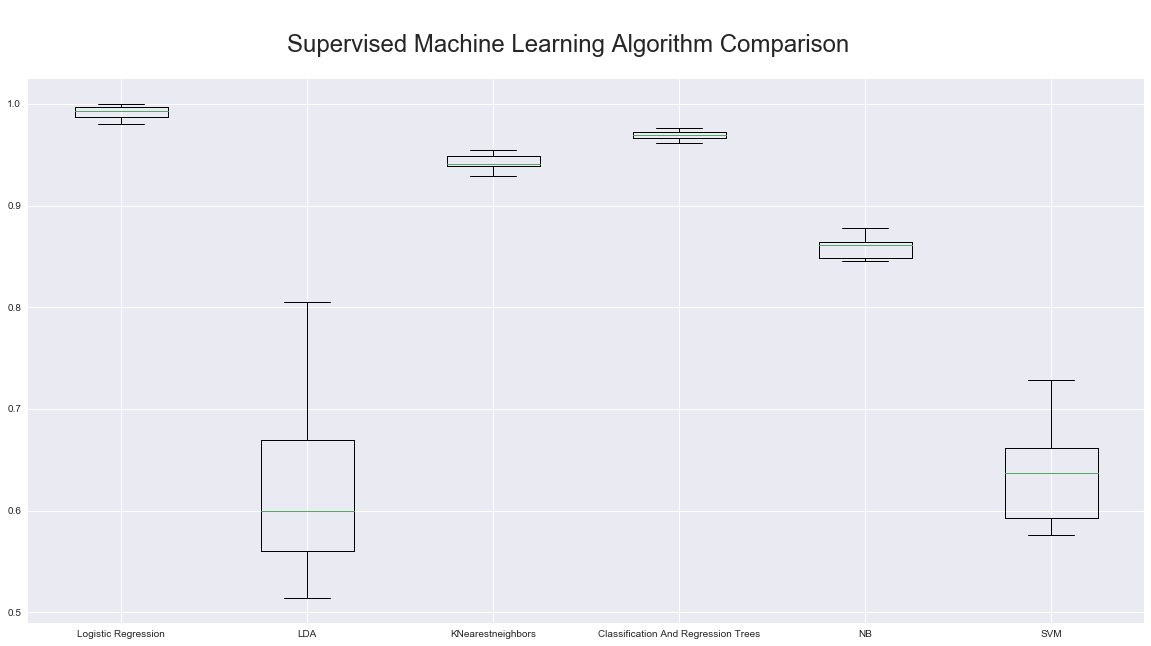

In [68]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,10))
fig.suptitle('\nSupervised Machine Learning Algorithm Comparison', size =24)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Random Forest model
- oob_score(out of bag)=True shows model performance with or without using Cross-Validation
- Generally the target follows a certain distribution and few observations, then using CV will not give much improvement.

In [97]:
RandomForestmodel = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = 1,random_state =1)

In [98]:
RandomForestmodel.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [99]:
RandomForestmodel_2 = RandomForestClassifier(n_estimators = 100,oob_score = True, n_jobs = -1, random_state=1)

In [100]:
RandomForestmodel_2.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

## another Random forest Model

In [101]:
RF_model =  RandomForestRegressor(n_estimators = 100 , oob_score =True, random_state = 42)

In [102]:
RF_model.fit(X,y).feature_importances_

array([  5.32733481e-02,   5.82420115e-02,   5.68543669e-03,
         5.42954668e-02,   4.81342570e-04,   5.59988183e-02,
         1.16570321e-03,   7.89451257e-04,   7.51200632e-01,
         4.06927589e-03,   2.47228557e-03,   6.82354293e-03,
         5.16167175e-04,   4.98651749e-03])

In [103]:
RF_model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [104]:
RF_model.feature_importances_

array([  5.32733481e-02,   5.82420115e-02,   5.68543669e-03,
         5.42954668e-02,   4.81342570e-04,   5.59988183e-02,
         1.16570321e-03,   7.89451257e-04,   7.51200632e-01,
         4.06927589e-03,   2.47228557e-03,   6.82354293e-03,
         5.16167175e-04,   4.98651749e-03])

In [105]:
print "AUC - ROC : ", roc_auc_score(y, RF_model.oob_prediction_)

AUC - ROC :  0.99880608417


In [106]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jg/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


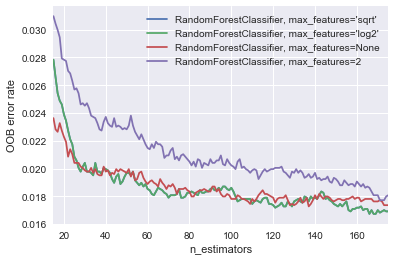

In [107]:
# this cell takes about 90 seconds to run
RANDOM_STATE = 42
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=2",
        RandomForestClassifier(warm_start=True, max_features=2,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

#### Twice the estimators
and multiple leaf options using the regressor

In [108]:
%time  
%timeit
sample_leaf_options = [1,5,10,50,100,200,500]
for leaf_size in sample_leaf_options :
    model_RF_loop = RandomForestRegressor(
        n_estimators = 200, 
        oob_score = True, 
        n_jobs = -1,
        random_state = 42,
        max_features = "auto", 
        min_samples_leaf = leaf_size)
    model_RF_loop.fit(X, y)
    print "Leaf Size:", leaf_size, "    AUC - ROC : ", roc_auc_score(y, model_RF_loop.oob_prediction_ )

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 17.2 µs
Leaf Size: 1     AUC - ROC :  0.998862990345
Leaf Size: 5     AUC - ROC :  0.998787198568
Leaf Size: 10     AUC - ROC :  0.99849487073
Leaf Size: 50     AUC - ROC :  0.996633707966
Leaf Size: 100     AUC - ROC :  0.995006188027
Leaf Size: 200     AUC - ROC :  0.991450208742
Leaf Size: 500     AUC - ROC :  0.988021341528


Group the data in ways that shows insights

It would be useful to see the data grouped by airport and count of late arrivals

In [117]:
# # this little for loop helps find the column numbers when slicing with .iloc
# for i, x in enumerate(data.columns):
#     print("%d. %s"%(i, x))

In [78]:
# late_count = data.iloc[:, [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 7]]
# late_count.corr()

In [120]:
denver_by_carrier.index.values

array([('DEN', 'AA'), ('DEN', 'AS'), ('DEN', 'B6'), ('DEN', 'DL'),
       ('DEN', 'F9'), ('DEN', 'NK'), ('DEN', 'OO'), ('DEN', 'UA'),
       ('DEN', 'VX'), ('DEN', 'WN')], dtype=object)

In [126]:
air_port, carrier_ = zip(*denver_by_carrier.index.values)
print (air_port),
print "\n"
print (carrier_)

('DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN', 'DEN') 

('AA', 'AS', 'B6', 'DL', 'F9', 'NK', 'OO', 'UA', 'VX', 'WN')
